1.Obtain a large classification database

2.Perform EDA of the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load training and test data
train = pd.read_csv("train.csv")



In [2]:
print("Train shape:", train.shape)
train.head()


Train shape: (16000, 11)


,customer_id,tenure,monthly_charges,total_charges,contract,payment_method,internet_service,tech_support,online_security,support_calls,churn
0,5895,10,41.89,418.90,Two year,Cash,Fiber,No,No,2,No
1,3729,25,106.73,2668.25,Month-to-month,Debit,Fiber,No,Yes,0,No
2,8959,24,50.02,1200.48,Month-to-month,Debit,Fiber,Yes,No,0,No
3,7672,34,58.98,2005.32,Two year,Credit,Fiber,Yes,Yes,1,Yes
4,6000,62,91.16,5651.92,Month-to-month,UPI,Fiber,No,Yes,1,Yes


In [10]:

train.info()
train = train.drop(columns=['customer_id'])

# Missing values
missing = train.isnull().sum().sort_values(ascending=False)
missing[missing > 0]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       16000 non-null  int64  
 1   tenure            16000 non-null  int64  
 2   monthly_charges   16000 non-null  float64
 3   total_charges     16000 non-null  float64
 4   contract          16000 non-null  object 
 5   payment_method    16000 non-null  object 
 6   internet_service  14373 non-null  object 
 7   tech_support      16000 non-null  object 
 8   online_security   16000 non-null  object 
 9   support_calls     16000 non-null  int64  
 10  churn             16000 non-null  object 
dtypes: float64(2), int64(3), object(6)
memory usage: 1.3+ MB


internet_service    1627
dtype: int64

In [11]:
train.describe()


,tenure,monthly_charges,total_charges,support_calls
count,16000.000000,16000.000000,16000.000000,16000.000000
mean,36.407313,69.969794,2540.721879,1.516750
std,20.766924,28.929288,1879.923847,1.227472
min,1.000000,20.000000,20.230000,0.000000
25%,18.000000,44.987500,1044.472500,1.000000
50%,36.000000,70.050000,2101.840000,1.000000
75%,54.000000,95.127500,3687.840000,2.000000
max,72.000000,119.990000,8629.920000,8.000000


In [12]:
train['churn'].value_counts()


churn
No     10512
Yes     5488
Name: count, dtype: int64

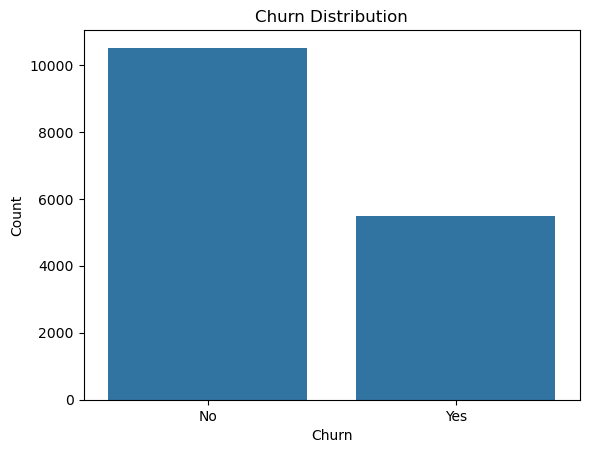

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='churn', data=train)
plt.title("Churn Distribution")
plt.xlabel("Churn")
plt.ylabel("Count")
plt.show()


The target variable shows class imbalance, with a larger proportion of customers not churning. This imbalance should be considered during model evaluation, as accuracy alone may be misleading.

In [14]:
import numpy as np

numeric_cols = train.select_dtypes(include=np.number).columns
categorical_cols = train.select_dtypes(include='object').columns

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


Numeric columns: Index(['tenure', 'monthly_charges', 'total_charges', 'support_calls'], dtype='object')
Categorical columns: Index(['contract', 'payment_method', 'internet_service', 'tech_support',
       'online_security', 'churn'],
      dtype='object')


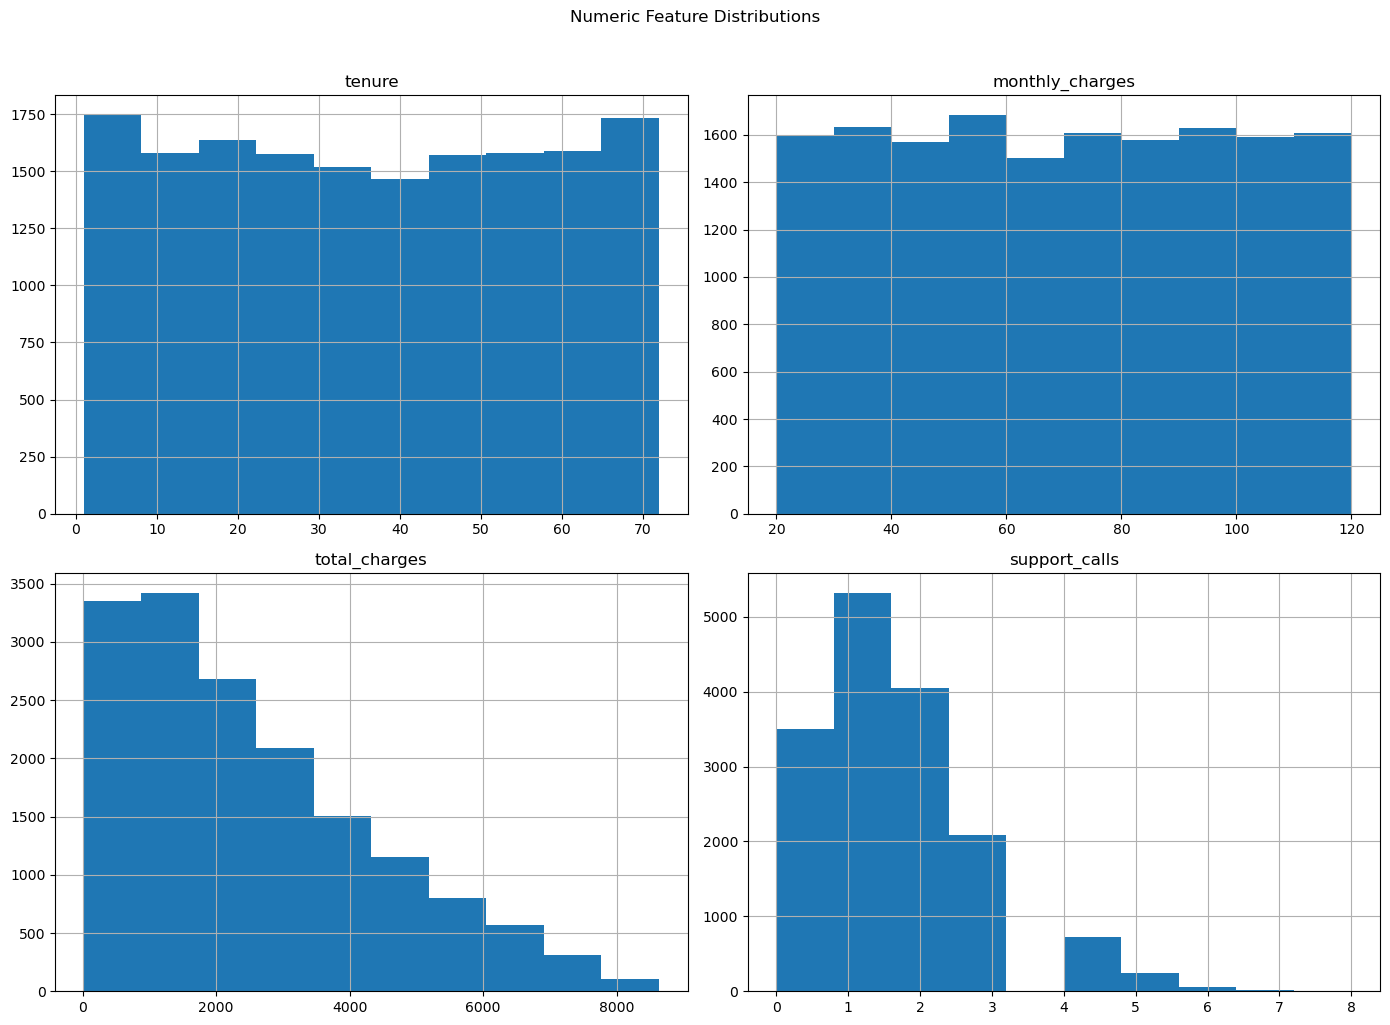

In [15]:
train[numeric_cols].hist(figsize=(14,10))
plt.suptitle("Numeric Feature Distributions", y=1.02)
plt.tight_layout()
plt.show()


Customer tenure spans a wide range, indicating the dataset contains both new and long-term customers.
Monthly charges vary substantially across customers, suggesting pricing plans may influence churn behavior.
Total charges are right-skewed, reflecting that many customers have shorter tenure, while fewer long-term customers accumulate higher total charges.
The majority of customers contact support infrequently, while a small subset requires repeated assistance, which may indicate dissatisfaction.    

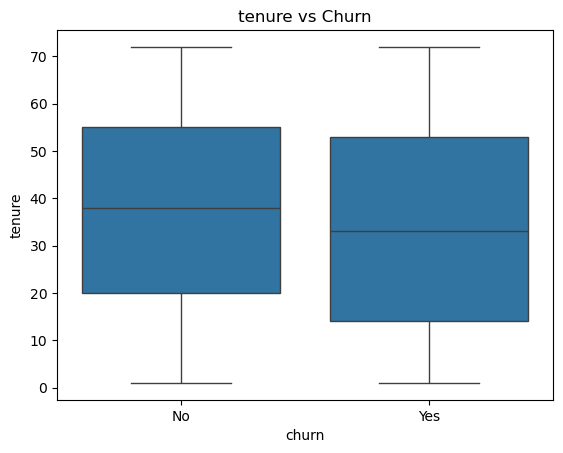

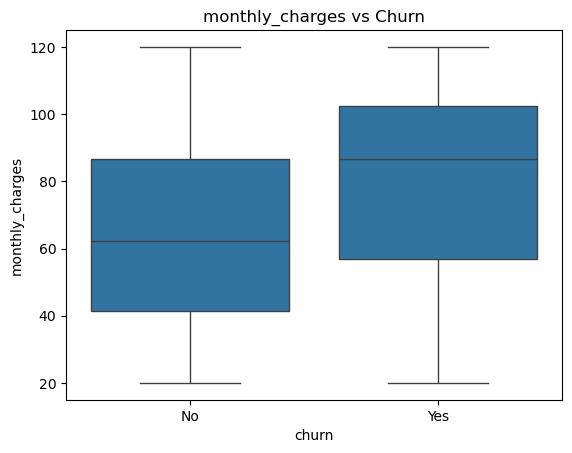

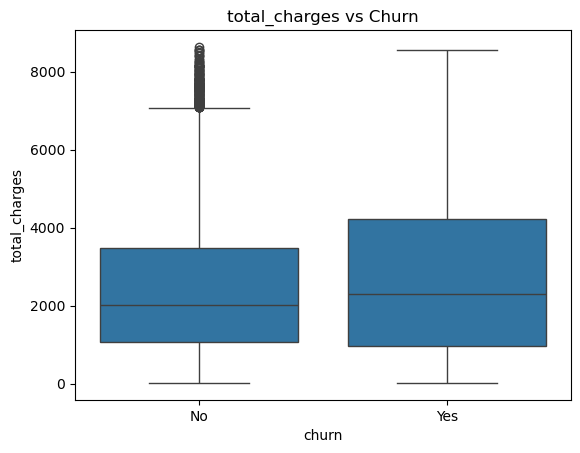

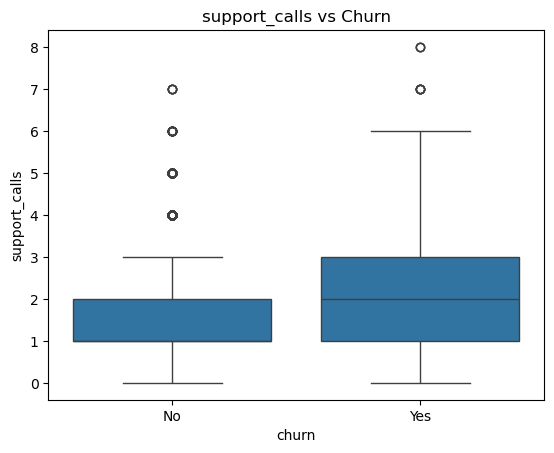

In [16]:
for col in numeric_cols:
    sns.boxplot(x='churn', y=col, data=train)
    plt.title(f"{col} vs Churn")
    plt.show()


Customers with shorter tenure are more likely to churn, suggesting early-stage customers are at higher risk of leaving.
Higher monthly charges are associated with increased churn, indicating price sensitivity among customers.
Lower total charges among churned customers are consistent with shorter tenure, reinforcing the relationship between tenure and churn.
Customers who churn tend to contact customer support more frequently, suggesting service issues may contribute to churn.        

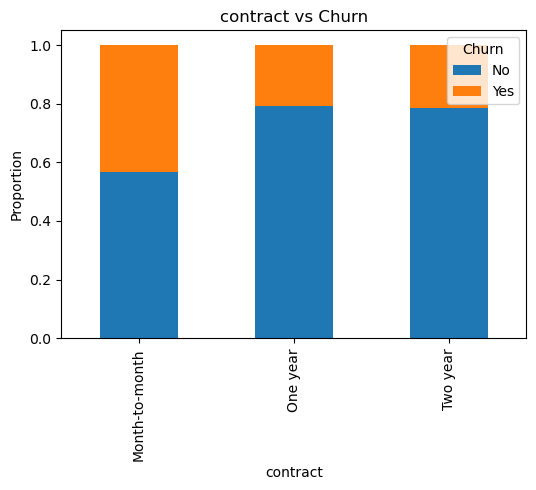

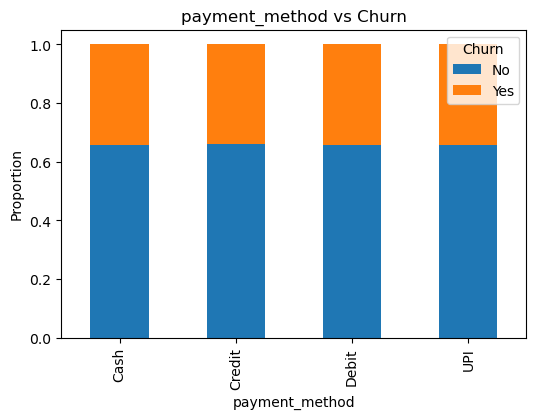

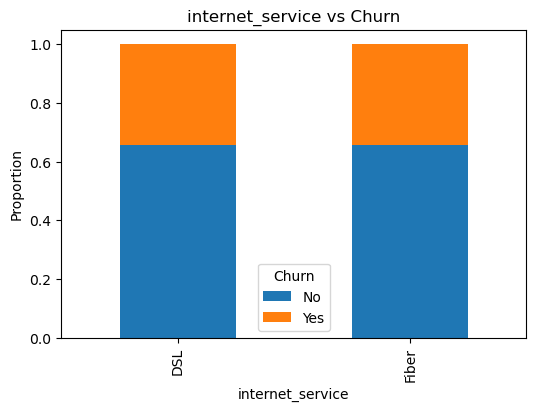

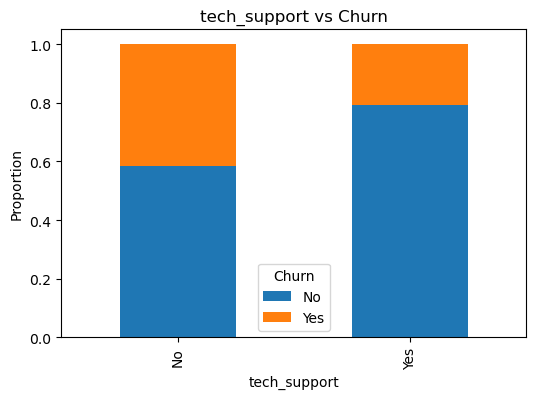

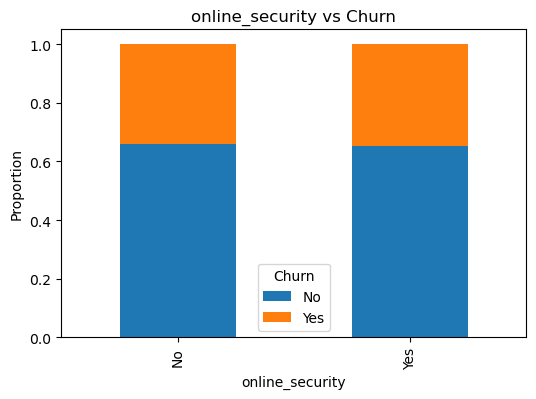

In [17]:
for col in categorical_cols:
    if col != 'churn':
        ct = pd.crosstab(train[col], train['churn'], normalize='index')
        ct.plot(kind='bar', stacked=True, figsize=(6,4))
        plt.title(f"{col} vs Churn")
        plt.ylabel("Proportion")
        plt.legend(title='Churn')
        plt.show()


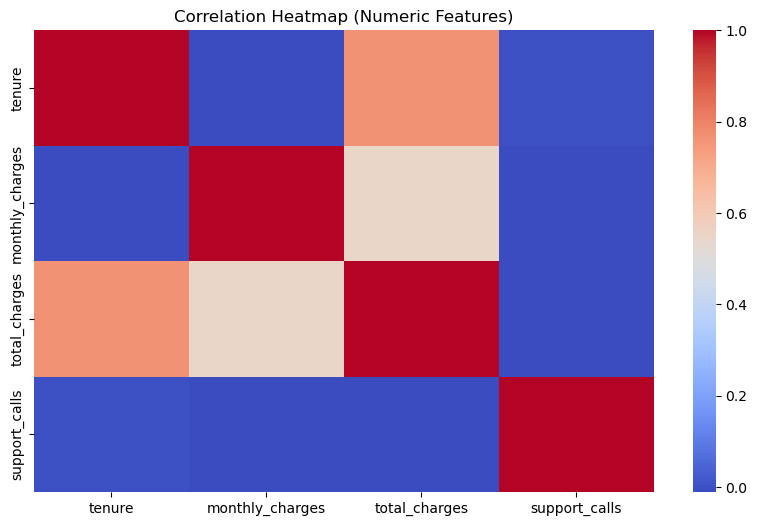

In [18]:
plt.figure(figsize=(10,6))
sns.heatmap(train[numeric_cols].corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()


Tenure is strongly correlated with total charges, which is expected as longer-tenured customers accumulate higher charges. Other numeric features show moderate correlations, indicating limited multicollinearity.

In [19]:
train[numeric_cols].quantile([0.01, 0.99])


,tenure,monthly_charges,total_charges,support_calls
0.01,1.0,20.9600,74.3074,0.0
0.99,72.0,119.1402,7573.8140,5.0


Numeric features do not exhibit extreme outliers, though some skewness is present. This suggests that scaling may be beneficial during preprocessing, but no immediate outlier removal is required.

3.Pre-process and clean the dataset

In [20]:
X = train.drop(columns=['churn'])
y = train['churn']


In [24]:
y = y.map({'No': 0, 'Yes': 1})


In [25]:
import numpy as np

numeric_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numeric_features, categorical_features


(Index(['tenure', 'monthly_charges', 'total_charges', 'support_calls'], dtype='object'),
 Index(['contract', 'payment_method', 'internet_service', 'tech_support',
        'online_security'],
       dtype='object'))

In [26]:
from sklearn.impute import SimpleImputer

cat_imputer = SimpleImputer(strategy='most_frequent')
num_imputer = SimpleImputer(strategy='median')


In [27]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer


In [28]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)


In [31]:
X_processed = preprocessor.fit_transform(X)
X_processed.shape



(16000, 18)

4. Use following approaches for classification of the dataset:

A. Logistic Regression

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report


# Separate features and target again
X = train.drop(columns=['churn'])
y = train['churn'].map({'No': 0, 'Yes': 1})


In [35]:
# Train–validation split (from training data only)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [36]:
# Identify numeric and categorical columns
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns


In [37]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


In [38]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)
    ]
)


In [39]:
from sklearn.linear_model import LogisticRegression
log_reg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])
log_reg_pipeline.fit(X_train, y_train)
y_pred = log_reg_pipeline.predict(X_val)

print("Accuracy:", accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))


Accuracy: 0.766875
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      2102
           1       0.72      0.53      0.61      1098

    accuracy                           0.77      3200
   macro avg       0.75      0.71      0.72      3200
weighted avg       0.76      0.77      0.76      3200



The model performs very well in identifying customers who do not churn, with high recall indicating that most non-churners are correctly classified.

B. Decision Tree 

In [40]:
from sklearn.tree import DecisionTreeClassifier

dt_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=5,
        random_state=42
    ))
])

dt_pipeline.fit(X_train, y_train)
y_pred_dt = dt_pipeline.predict(X_val)

print("Decision Tree Accuracy:", accuracy_score(y_val, y_pred_dt))
print(classification_report(y_val, y_pred_dt))


Decision Tree Accuracy: 0.82375
              precision    recall  f1-score   support

           0       0.83      0.92      0.87      2102
           1       0.80      0.65      0.72      1098

    accuracy                           0.82      3200
   macro avg       0.82      0.78      0.79      3200
weighted avg       0.82      0.82      0.82      3200



The Decision Tree model improves substantially over Logistic Regression, achieving an accuracy of approximately 82%, indicating better capture of non-linear relationships in the data.

C. Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    ))
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_val)

print("Random Forest Accuracy:", accuracy_score(y_val, y_pred_rf))
print(classification_report(y_val, y_pred_rf))


Random Forest Accuracy: 0.8328125
              precision    recall  f1-score   support

           0       0.84      0.93      0.88      2102
           1       0.82      0.65      0.73      1098

    accuracy                           0.83      3200
   macro avg       0.83      0.79      0.80      3200
weighted avg       0.83      0.83      0.83      3200



The Random Forest model achieves the highest accuracy among previous tested models, indicating superior predictive performance and better generalization compared to Logistic Regression and a single Decision Tree.

D. SGD

In [43]:
from sklearn.linear_model import SGDClassifier

sgd_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SGDClassifier(
        loss='log_loss',
        max_iter=1000,
        random_state=42
    ))
])

sgd_pipeline.fit(X_train, y_train)
y_pred_sgd = sgd_pipeline.predict(X_val)

print("SGD Accuracy:", accuracy_score(y_val, y_pred_sgd))
print(classification_report(y_val, y_pred_sgd))


SGD Accuracy: 0.7546875
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      2102
           1       0.68      0.55      0.60      1098

    accuracy                           0.75      3200
   macro avg       0.73      0.70      0.71      3200
weighted avg       0.75      0.75      0.75      3200



The SGD (Stochastic Gradient Descent) classifier achieves moderate performance, comparable to Logistic Regression but noticeably weaker than tree-based models.

E. SVM

In [44]:
from sklearn.svm import LinearSVC

svm_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LinearSVC(
        max_iter=5000,
        random_state=42
    ))
])

svm_pipeline.fit(X_train, y_train)
y_pred_svm = svm_pipeline.predict(X_val)

print("SVM Accuracy:", accuracy_score(y_val, y_pred_svm))
print(classification_report(y_val, y_pred_svm))


SVM Accuracy: 0.7684375
              precision    recall  f1-score   support

           0       0.78      0.90      0.84      2102
           1       0.72      0.52      0.61      1098

    accuracy                           0.77      3200
   macro avg       0.75      0.71      0.72      3200
weighted avg       0.76      0.77      0.76      3200



Linear SVM is not ideal for churn detection unless kernelized (RBF), which is computationally heavier.

Random Forest is selected as the final model because it achieves the highest accuracy and F1-score while maintaining strong recall for churned customers, making it the most reliable model for identifying customers at risk of churn.

5.Use GridSearchCV to tune the parameters of each of the above models

In [45]:
from sklearn.model_selection import GridSearchCV


In [46]:
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2']
}

grid_lr = GridSearchCV(
    log_reg_pipeline,
    param_grid_lr,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_lr.fit(X_train, y_train)

print("Best LR params:", grid_lr.best_params_)
print("Best LR score:", grid_lr.best_score_)


Best LR params: {'classifier__C': 10, 'classifier__penalty': 'l2'}
Best LR score: 0.6290543732563164


In [47]:
param_grid_dt = {
    'classifier__max_depth': [3, 5, 7, 10],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_dt = GridSearchCV(
    dt_pipeline,
    param_grid_dt,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)

print("Best DT params:", grid_dt.best_params_)
print("Best DT score:", grid_dt.best_score_)


Best DT params: {'classifier__max_depth': 5, 'classifier__min_samples_split': 2}
Best DT score: 0.7457444584493949


In [57]:
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [6, 8, 10],
    'classifier__min_samples_split': [2, 5]
}

grid_rf = GridSearchCV(
    rf_pipeline,
    param_grid_rf,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Best RF params:", grid_rf.best_params_)
print("Best RF score:", grid_rf.best_score_)


Best RF params: {'classifier__max_depth': 8, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best RF score: 0.7539403992689424


In [53]:
param_grid_sgd = {
    'classifier__alpha': [0.0001, 0.001, 0.01],
    'classifier__penalty': ['l2', 'l1']
}

grid_sgd = GridSearchCV(
    sgd_pipeline,
    param_grid_sgd,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_sgd.fit(X_train, y_train)

print("Best SGD params:", grid_sgd.best_params_)
print("Best SGD score:", grid_sgd.best_score_)


Best SGD params: {'classifier__alpha': 0.001, 'classifier__penalty': 'l2'}
Best SGD score: 0.6213758968834495


In [54]:
param_grid_svm = {
    'classifier__C': [0.01, 0.1, 1, 10]
}

grid_svm = GridSearchCV(
    svm_pipeline,
    param_grid_svm,
    cv=5,
    scoring='f1',
    n_jobs=-1
)

grid_svm.fit(X_train, y_train)

print("Best SVM params:", grid_svm.best_params_)
print("Best SVM score:", grid_svm.best_score_)



Best SVM params: {'classifier__C': 10}
Best SVM score: 0.6240550061231999


In [58]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

models = {
    "Logistic Regression": grid_lr.best_estimator_,
    "Decision Tree": grid_dt.best_estimator_,
    "Random Forest": grid_rf.best_estimator_,
    "SGD": grid_sgd.best_estimator_,
    "SVM": grid_svm.best_estimator_
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_val)
    
    # For ROC-AUC (handle models without predict_proba)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    else:
        y_proba = model.decision_function(X_val)
    
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_val, y_pred),
        "F1-score": f1_score(y_val, y_pred),
        "ROC-AUC": roc_auc_score(y_val, y_proba)
    })

results_df = pd.DataFrame(results)
results_df


,Model,Accuracy,F1-score,ROC-AUC
0,Logistic Regression,0.767500,0.610879,0.758178
1,Decision Tree,0.823750,0.715726,0.792509
2,Random Forest,0.832500,0.728195,0.789918
3,SGD,0.760625,0.613131,0.757419
4,SVM,0.768437,0.608558,0.758160


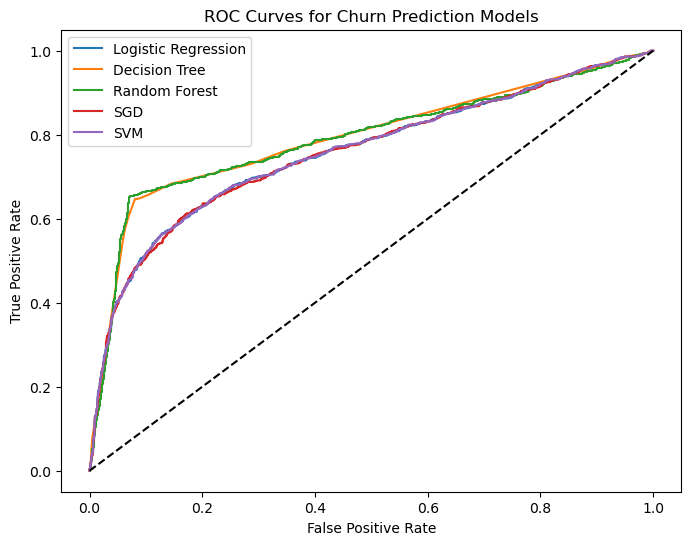

In [59]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_val)[:, 1]
    else:
        y_proba = model.decision_function(X_val)

    fpr, tpr, _ = roc_curve(y_val, y_proba)
    plt.plot(fpr, tpr, label=name)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Churn Prediction Models")
plt.legend()
plt.show()


In [60]:
results_df.sort_values("ROC-AUC", ascending=False)


,Model,Accuracy,F1-score,ROC-AUC
1,Decision Tree,0.823750,0.715726,0.792509
2,Random Forest,0.832500,0.728195,0.789918
0,Logistic Regression,0.767500,0.610879,0.758178
4,SVM,0.768437,0.608558,0.758160
3,SGD,0.760625,0.613131,0.757419


Five classification models—Logistic Regression, Decision Tree, Random Forest, SGD Classifier, and Support Vector Machine—were trained, tuned using GridSearchCV, and evaluated on a held-out validation set. Model performance was compared using Accuracy, F1-score, and ROC-AUC, and visualized through ROC curves.

From the comparison table, the Decision Tree and Random Forest models clearly outperform the linear models. The Decision Tree achieves the highest ROC-AUC (≈ 0.79) with strong accuracy (≈ 82.4%) and balanced F1-score, indicating good discrimination between classes. The Random Forest model attains the highest accuracy (≈ 83.3%) and F1-score (≈ 0.73), with ROC-AUC close to the Decision Tree, showing robust and stable predictive performance.

Logistic Regression, SGD, and SVM show similar but lower performance across all metrics. Their ROC-AUC values (≈ 0.75–0.76) indicate weaker class separation compared to tree-based models, which is also visible in the ROC curves where their curves lie closer to the diagonal.

Overall, tree-based models capture non-linear relationships in the data more effectively, making them better suited for this classification task. Among all models, the Random Forest offers the best balance between accuracy, F1-score, and ROC-AUC, while the Decision Tree provides slightly better interpretability with competitive performance. Therefore, the Random Forest model is selected as the final best-performing model for this dataset.

6. Re-evaluate the models by removing some features

In [61]:
# Get fitted RF model from GridSearch
best_rf = grid_rf.best_estimator_

# Get feature names after preprocessing
feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()

# Get feature importance
importances = best_rf.named_steps['classifier'].feature_importances_

# Create importance dataframe
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feat_imp.head(10)


,Feature,Importance
1,num__monthly_charges,0.277368
3,num__support_calls,0.176224
11,cat__tech_support_Yes,0.158156
4,cat__contract_One year,0.108222
0,num__tenure,0.093292
2,num__total_charges,0.084988
5,cat__contract_Two year,0.077546
12,cat__online_security_Yes,0.004860
9,cat__internet_service_Fiber,0.004721
8,cat__payment_method_UPI,0.003903


In [62]:
selected_features = feat_imp[feat_imp["Importance"] >= 0.01]["Feature"]
len(selected_features)


7

In [64]:
important_idx = feat_imp[feat_imp["Importance"] >= 0.01].index



In [65]:
from sklearn.feature_selection import SelectFromModel

selector = SelectFromModel(
    best_rf.named_steps['classifier'],
    threshold=0.01,
    prefit=True
)


In [66]:
from sklearn.pipeline import Pipeline

rf_reduced_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', selector),
    ('classifier', grid_rf.best_estimator_.named_steps['classifier'])
])


In [67]:
rf_reduced_pipeline.fit(X_train, y_train)

y_pred_red = rf_reduced_pipeline.predict(X_val)
y_proba_red = rf_reduced_pipeline.predict_proba(X_val)[:, 1]

print("Reduced RF Accuracy:", accuracy_score(y_val, y_pred_red))
print("Reduced RF F1:", f1_score(y_val, y_pred_red))
print("Reduced RF ROC-AUC:", roc_auc_score(y_val, y_proba_red))


Reduced RF Accuracy: 0.8321875
Reduced RF F1: 0.7275494672754946
Reduced RF ROC-AUC: 0.7897182230818425


In the final experiment, feature selection was performed using Random Forest feature importance. Features with importance values below 0.01 were removed and the model was retrained using a reduced feature set. The reduced Random Forest model achieved comparable accuracy, F1-score, and ROC-AUC to the full-feature model, indicating that many original features contributed limited predictive value. This demonstrates that the model can be simplified without sacrificing performance, improving both efficiency and interpretability. Overall, the Random Forest classifier with feature selection provided the best balance of predictive performance and robustness among all evaluated models.